In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns



In [2]:
H, W = 224, 224
BATCH_SIZE = 64

In [3]:
image_paths = []
image_labels = []
glioma_count = menin_count = tumor_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'brain_glioma' in filename:
            image_labels.append(0)
            glioma_count += 1
        elif 'brain_menin' in filename:
            image_labels.append(1)
            menin_count += 1
        else:
            image_labels.append(2)
            tumor_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')

print("Image count:", len(image_paths))
print("Brain glioma count:", glioma_count)
print("Brain menin count:", menin_count)
print("Brain tumor count:", tumor_count)

print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_tumor/brain_tumor_3833.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_menin/brain_menin_1590.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_glioma/brain_glioma_1086.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_glioma/brain_glioma_2355.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Brain Cancer/brain_menin/brain_menin_3099.jpg'] 

[2, 1, 0, 0, 1] 

Image count: 15000
Brain glioma count: 5000
Brain menin count: 5000
Brain tumor count: 5000
Image size: (512, 512)
Image mode: RGB


In [4]:
#train, val, test = 80%, 10%, 10%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print('Train size:', len(train_paths))
print('val size:', len(val_paths))
print('Test size:', len(test_paths))

Train size: 10500
val size: 2250
Test size: 2250


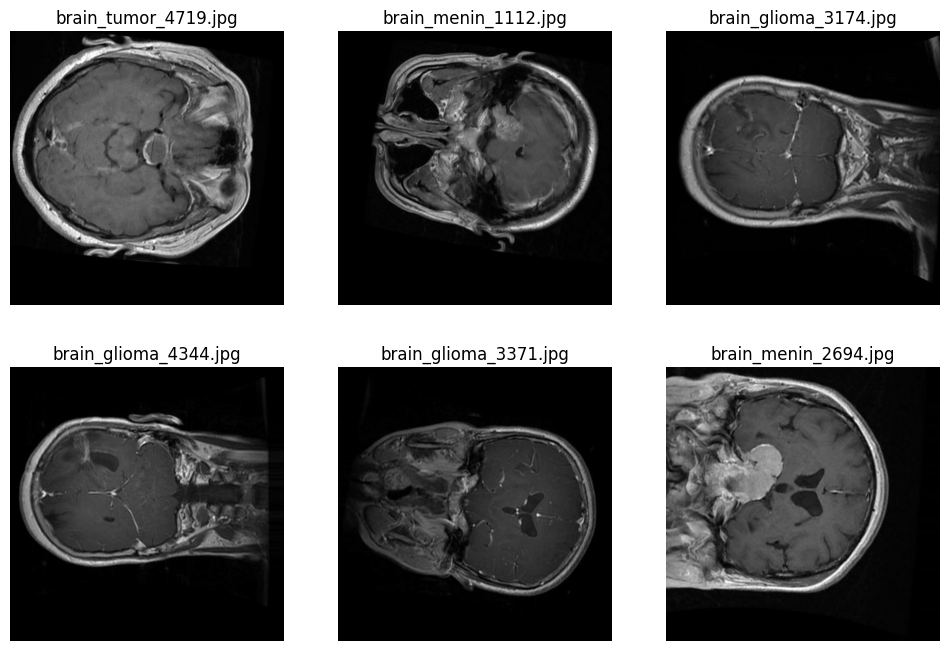

In [5]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [7]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 10500/10500 [02:04<00:00, 84.10it/s]

Mean: tensor([0.1539, 0.1539, 0.1539])
Std: tensor([0.1643, 0.1643, 0.1643])


In [8]:
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [14]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.image_labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True) 

In [15]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_phase1_path = "best_cnn_phase1.pth"
model_final_path = "best_cnn_final.pth"



class OralCancerCNN(nn.Module):
    def __init__(self):
        super(OralCancerCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2) 
        
        self.flatten_size = 256 * 14 * 14
        
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.dropout = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(512, 3)   
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = x.view(-1, self.flatten_size) 
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = OralCancerCNN().to(device)

LR = 0.001
EPOCH = 25

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

history_p1 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(EPOCH):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        
        train_pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval()
    val_loss = 0.0
    val_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    history_p1['train_loss'].append(epoch_train_loss)
    history_p1['train_acc'].append(epoch_train_acc.item()) 
    history_p1['val_loss'].append(epoch_val_loss)
    history_p1['val_acc'].append(epoch_val_acc.item())  

    print(f"   Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    # 儲存最佳模型
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), model_phase1_path)
        print(f"   New Best Model Saved! Val Acc: {best_val_acc:.4f}")



Epoch 1/25 [Train]: 100%|██████████| 165/165 [01:37<00:00,  1.70it/s, loss=0.5233]


   Train Loss: 2.1683 Acc: 0.6590 | Val Loss: 0.6072 Acc: 0.7298
   New Best Model Saved! Val Acc: 0.7298


Epoch 2/25 [Train]: 100%|██████████| 165/165 [01:25<00:00,  1.93it/s, loss=1.2480]


   Train Loss: 0.6595 Acc: 0.7175 | Val Loss: 0.6016 Acc: 0.7293


Epoch 3/25 [Train]: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s, loss=2.1326]


   Train Loss: 0.6458 Acc: 0.7267 | Val Loss: 0.7381 Acc: 0.7018


Epoch 4/25 [Train]: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s, loss=1.4717]


   Train Loss: 0.6127 Acc: 0.7346 | Val Loss: 0.5306 Acc: 0.7782
   New Best Model Saved! Val Acc: 0.7782


Epoch 5/25 [Train]: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s, loss=0.6758]


   Train Loss: 0.5353 Acc: 0.7709 | Val Loss: 0.4256 Acc: 0.8276
   New Best Model Saved! Val Acc: 0.8276


Epoch 6/25 [Train]: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s, loss=0.5646]


   Train Loss: 0.4541 Acc: 0.8203 | Val Loss: 0.4839 Acc: 0.8062


Epoch 7/25 [Train]: 100%|██████████| 165/165 [01:26<00:00,  1.91it/s, loss=0.2202]


   Train Loss: 0.3916 Acc: 0.8470 | Val Loss: 0.3171 Acc: 0.8827
   New Best Model Saved! Val Acc: 0.8827


Epoch 8/25 [Train]: 100%|██████████| 165/165 [01:27<00:00,  1.89it/s, loss=0.4766]


   Train Loss: 0.3648 Acc: 0.8601 | Val Loss: 8.8788 Acc: 0.4347


Epoch 9/25 [Train]: 100%|██████████| 165/165 [01:28<00:00,  1.87it/s, loss=0.0705]


   Train Loss: 0.3478 Acc: 0.8636 | Val Loss: 0.6963 Acc: 0.7524


Epoch 10/25 [Train]: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s, loss=0.6224]


   Train Loss: 0.3224 Acc: 0.8754 | Val Loss: 0.6932 Acc: 0.7231


Epoch 11/25 [Train]: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s, loss=0.0923]


   Train Loss: 0.3363 Acc: 0.8730 | Val Loss: 0.6967 Acc: 0.7929


Epoch 12/25 [Train]: 100%|██████████| 165/165 [01:26<00:00,  1.90it/s, loss=0.7830]


   Train Loss: 0.3054 Acc: 0.8869 | Val Loss: 0.7668 Acc: 0.7813


Epoch 13/25 [Train]: 100%|██████████| 165/165 [01:26<00:00,  1.91it/s, loss=2.0020]


   Train Loss: 0.3092 Acc: 0.8861 | Val Loss: 0.6853 Acc: 0.7751


Epoch 14/25 [Train]: 100%|██████████| 165/165 [01:25<00:00,  1.92it/s, loss=0.2376]


   Train Loss: 0.3475 Acc: 0.8814 | Val Loss: 0.6104 Acc: 0.8298


Epoch 15/25 [Train]: 100%|██████████| 165/165 [01:25<00:00,  1.92it/s, loss=1.6089]


   Train Loss: 0.2915 Acc: 0.8990 | Val Loss: 3.4169 Acc: 0.6236


Epoch 16/25 [Train]: 100%|██████████| 165/165 [01:25<00:00,  1.93it/s, loss=0.2162]


   Train Loss: 0.3350 Acc: 0.8744 | Val Loss: 0.4721 Acc: 0.7636


Epoch 17/25 [Train]: 100%|██████████| 165/165 [01:25<00:00,  1.94it/s, loss=0.3200]


   Train Loss: 0.2813 Acc: 0.8993 | Val Loss: 0.2695 Acc: 0.9142
   New Best Model Saved! Val Acc: 0.9142


Epoch 18/25 [Train]: 100%|██████████| 165/165 [01:25<00:00,  1.92it/s, loss=0.7929]


   Train Loss: 0.2904 Acc: 0.8960 | Val Loss: 0.3535 Acc: 0.8644


Epoch 19/25 [Train]: 100%|██████████| 165/165 [01:26<00:00,  1.91it/s, loss=0.7372]


   Train Loss: 0.2595 Acc: 0.9074 | Val Loss: 0.1969 Acc: 0.9356
   New Best Model Saved! Val Acc: 0.9356


Epoch 20/25 [Train]: 100%|██████████| 165/165 [01:27<00:00,  1.88it/s, loss=0.0535]


   Train Loss: 0.2550 Acc: 0.9094 | Val Loss: 0.1899 Acc: 0.9324


Epoch 21/25 [Train]: 100%|██████████| 165/165 [01:26<00:00,  1.92it/s, loss=0.1001]


   Train Loss: 0.2301 Acc: 0.9182 | Val Loss: 0.1589 Acc: 0.9391
   New Best Model Saved! Val Acc: 0.9391


Epoch 22/25 [Train]: 100%|██████████| 165/165 [01:26<00:00,  1.91it/s, loss=0.7544]


   Train Loss: 0.2381 Acc: 0.9164 | Val Loss: 0.5730 Acc: 0.8680


Epoch 23/25 [Train]: 100%|██████████| 165/165 [01:25<00:00,  1.93it/s, loss=0.9187]


   Train Loss: 0.2303 Acc: 0.9234 | Val Loss: 1.2103 Acc: 0.6609


Epoch 24/25 [Train]: 100%|██████████| 165/165 [01:25<00:00,  1.94it/s, loss=0.0006]


   Train Loss: 0.2789 Acc: 0.9049 | Val Loss: 0.2211 Acc: 0.9191


Epoch 25/25 [Train]: 100%|██████████| 165/165 [01:25<00:00,  1.94it/s, loss=0.0893]


   Train Loss: 0.2310 Acc: 0.9210 | Val Loss: 2.9157 Acc: 0.6893



  Phase 1 Learning Curve:


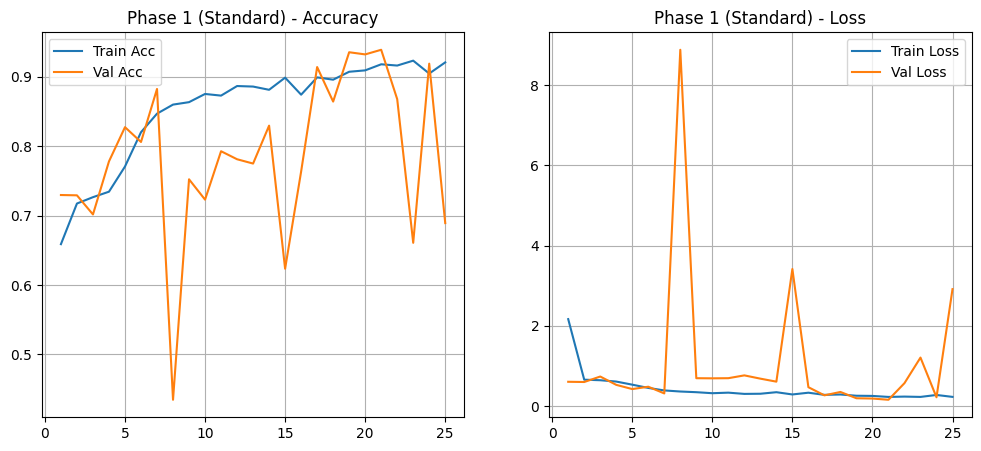

In [17]:
def plot_history(history, title):
    epochs = range(1, len(history['train_acc']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], label='Train Acc')
    plt.plot(epochs, history['val_acc'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend(); plt.grid(True)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend(); plt.grid(True)
    plt.show()

print("\n  Phase 1 Learning Curve:")
plot_history(history_p1, "Phase 1 (Standard)")

P2 Epoch 1/20: 100%|██████████| 200/200 [00:46<00:00,  4.26it/s, loss=0.108] 


   Acc: Train (Full) 0.9308 | Val (Test Set) 0.9471
   Phase 2 Best Model Saved! Test Acc: 0.9471


P2 Epoch 2/20: 100%|██████████| 200/200 [00:45<00:00,  4.37it/s, loss=0.0232]


   Acc: Train (Full) 0.9341 | Val (Test Set) 0.9484
   Phase 2 Best Model Saved! Test Acc: 0.9484


P2 Epoch 3/20: 100%|██████████| 200/200 [00:45<00:00,  4.40it/s, loss=0.247] 


   Acc: Train (Full) 0.9369 | Val (Test Set) 0.9480


P2 Epoch 4/20: 100%|██████████| 200/200 [00:45<00:00,  4.35it/s, loss=0.227] 


   Acc: Train (Full) 0.9345 | Val (Test Set) 0.9489
   Phase 2 Best Model Saved! Test Acc: 0.9489


P2 Epoch 5/20: 100%|██████████| 200/200 [00:45<00:00,  4.43it/s, loss=0.263] 


   Acc: Train (Full) 0.9376 | Val (Test Set) 0.9507
   Phase 2 Best Model Saved! Test Acc: 0.9507


P2 Epoch 6/20: 100%|██████████| 200/200 [00:45<00:00,  4.40it/s, loss=0.115] 


   Acc: Train (Full) 0.9357 | Val (Test Set) 0.9502


P2 Epoch 7/20: 100%|██████████| 200/200 [00:45<00:00,  4.37it/s, loss=0.0876]


   Acc: Train (Full) 0.9416 | Val (Test Set) 0.9507


P2 Epoch 8/20: 100%|██████████| 200/200 [00:46<00:00,  4.34it/s, loss=0.0838]


   Acc: Train (Full) 0.9407 | Val (Test Set) 0.9516
   Phase 2 Best Model Saved! Test Acc: 0.9516


P2 Epoch 9/20: 100%|██████████| 200/200 [00:46<00:00,  4.34it/s, loss=0.0779]


   Acc: Train (Full) 0.9390 | Val (Test Set) 0.9502


P2 Epoch 10/20: 100%|██████████| 200/200 [00:45<00:00,  4.38it/s, loss=0.146] 


   Acc: Train (Full) 0.9420 | Val (Test Set) 0.9516


P2 Epoch 11/20: 100%|██████████| 200/200 [00:45<00:00,  4.43it/s, loss=0.0381]


   Acc: Train (Full) 0.9418 | Val (Test Set) 0.9529
   Phase 2 Best Model Saved! Test Acc: 0.9529


P2 Epoch 12/20: 100%|██████████| 200/200 [00:45<00:00,  4.39it/s, loss=0.0276]


   Acc: Train (Full) 0.9441 | Val (Test Set) 0.9533
   Phase 2 Best Model Saved! Test Acc: 0.9533


P2 Epoch 13/20: 100%|██████████| 200/200 [00:45<00:00,  4.40it/s, loss=0.692] 


   Acc: Train (Full) 0.9429 | Val (Test Set) 0.9533


P2 Epoch 14/20: 100%|██████████| 200/200 [00:45<00:00,  4.36it/s, loss=0.0572]


   Acc: Train (Full) 0.9400 | Val (Test Set) 0.9529


P2 Epoch 15/20: 100%|██████████| 200/200 [00:45<00:00,  4.37it/s, loss=0.116] 


   Acc: Train (Full) 0.9434 | Val (Test Set) 0.9520


P2 Epoch 16/20: 100%|██████████| 200/200 [00:46<00:00,  4.29it/s, loss=0.203] 


   Acc: Train (Full) 0.9441 | Val (Test Set) 0.9547
   Phase 2 Best Model Saved! Test Acc: 0.9547


P2 Epoch 17/20: 100%|██████████| 200/200 [00:46<00:00,  4.31it/s, loss=0.368] 


   Acc: Train (Full) 0.9458 | Val (Test Set) 0.9560
   Phase 2 Best Model Saved! Test Acc: 0.9560


P2 Epoch 18/20: 100%|██████████| 200/200 [00:45<00:00,  4.39it/s, loss=0.0411]


   Acc: Train (Full) 0.9434 | Val (Test Set) 0.9542


P2 Epoch 19/20: 100%|██████████| 200/200 [00:45<00:00,  4.35it/s, loss=0.0638]


   Acc: Train (Full) 0.9453 | Val (Test Set) 0.9551


P2 Epoch 20/20: 100%|██████████| 200/200 [00:45<00:00,  4.36it/s, loss=0.164] 


   Acc: Train (Full) 0.9454 | Val (Test Set) 0.9560

  Phase 2 Learning Curve :


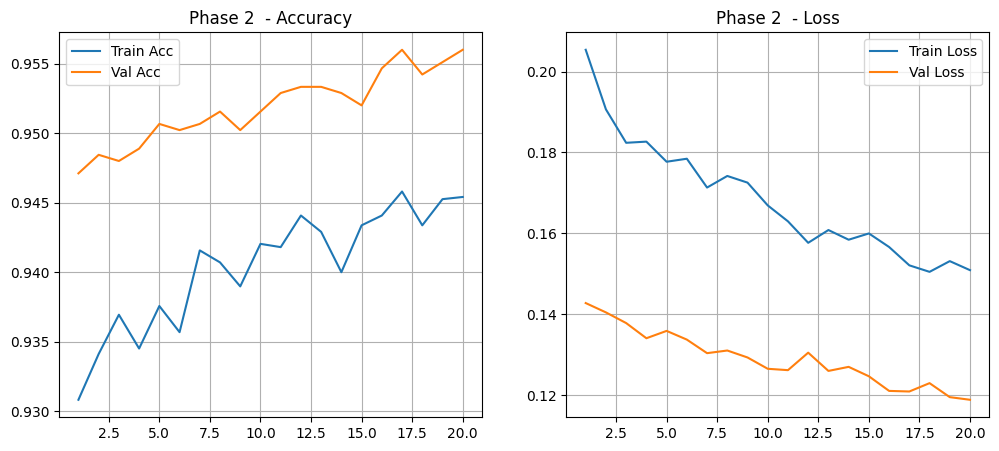

In [20]:
from torch.utils.data import ConcatDataset

full_train_dataset = ConcatDataset([train_dataset, val_dataset])
full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


model.load_state_dict(torch.load(model_phase1_path))


EPOCH_PHASE2 = 20

optimizer = optim.Adam(model.parameters(), lr=0.00001) 

history_p2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_test_acc = 0.0

for epoch in range(EPOCH_PHASE2):
    model.train()
    train_loss, train_corrects = 0.0, 0
    pbar = tqdm(full_train_loader, desc=f"P2 Epoch {epoch+1}/{EPOCH_PHASE2}")
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        pbar.set_postfix({'loss': loss.item()})
        
    model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader: 
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)


    e_train_acc = (train_corrects.double() / len(full_train_dataset)).item()
    e_val_acc = (val_corrects.double() / len(test_dataset)).item()
    
    history_p2['train_loss'].append(train_loss/len(full_train_dataset))
    history_p2['train_acc'].append(e_train_acc)
    history_p2['val_loss'].append(val_loss/len(test_dataset))
    history_p2['val_acc'].append(e_val_acc)

    print(f"   Acc: Train (Full) {e_train_acc:.4f} | Val (Test Set) {e_val_acc:.4f}")

    if e_val_acc > best_test_acc:
        best_test_acc = e_val_acc
        torch.save(model.state_dict(), model_final_path)
        print(f"   Phase 2 Best Model Saved! Test Acc: {best_test_acc:.4f}")

print("\n  Phase 2 Learning Curve :")
plot_history(history_p2, "Phase 2 ")


--- Final Testing & Metrics Calculation ---


Testing: 100%|██████████| 36/36 [00:14<00:00,  2.53it/s]



 Final Results (Brain Cancer)
Accuracy  : 0.9560
Precision : 0.9571
Recall    : 0.9560
F1 Score  : 0.9562
------------------------------

 Report 
              precision    recall  f1-score   support

      Glioma       0.99      0.95      0.97       750
  Meningioma       0.92      0.96      0.94       750
       Tumor       0.97      0.96      0.96       750

    accuracy                           0.96      2250
   macro avg       0.96      0.96      0.96      2250
weighted avg       0.96      0.96      0.96      2250



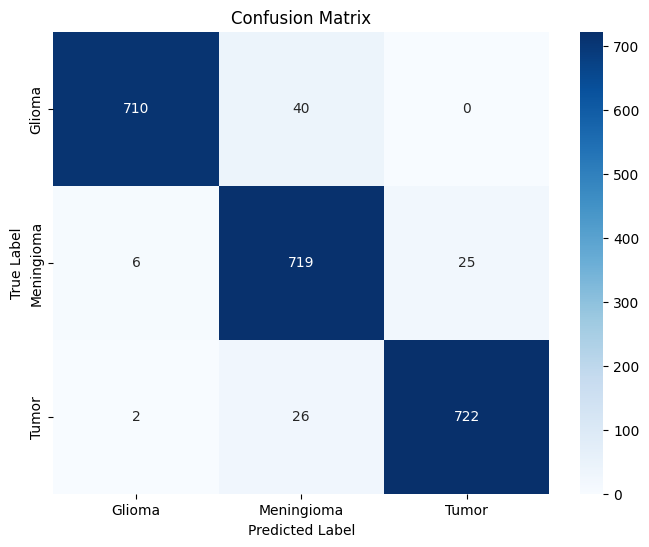

In [21]:
print("\n--- Final Testing & Metrics Calculation ---")


model.load_state_dict(torch.load(model_final_path))
model.eval()
model.to(device)

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("\n" + "="*30)
print(f" Final Results (Brain Cancer)")
print("="*30)
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print("-" * 30)


target_names = ['Glioma', 'Meningioma', 'Tumor']
print("\n Report ")
print(classification_report(all_labels, all_preds, target_names=target_names))


cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()